In [1]:
import sys112
print(sys.executable)

/home/disk/p/wycheng/anaconda3/envs/incubator2021/bin/python


In [2]:
import numpy as np
import scipy as sp
import dask
import pandas as pd
import xarray as xr
import matplotlib
from cycler import cycler
import matplotlib.pyplot as plt
import time

# Data Processing

### Set CONUS filter

In [3]:
import regionmask
import geopandas as gpd

In [4]:
PATH_TO_SHAPEFILE = '/home/disk/eos12/wycheng/data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)
indexes = np.arange(250).tolist()
countries_mask_poly = regionmask.Regions(name = 'COUNTRY', numbers = indexes, names = countries.CNTRY_NAME[indexes], abbrevs = countries.CNTRY_NAME[indexes], outlines = list(countries.geometry.values[i] for i in range(0,countries.shape[0])))

## Read WWLLN data

- Variable(s):
    - F (Lightning flash rate): The number of lightning strokes observed by WWLLN in each grid cell(# of strokes / grid / 3 hr).

In [5]:
WWLLN_dataset = xr.open_mfdataset('/home/disk/eos12/wycheng/data/WWLLN/Global/WWLLN_20*.nc', 
                                  chunks={'Time':'auto','lat':'auto','lon':'auto'},
                                  parallel=True,
                                 )

Select the CONUS area

In [6]:
WWLLN_dataset = WWLLN_dataset.sel(lon=slice(-125,-65),lat=slice(20,50))

Change the temporal resolution from 3 hours to 1 day 
- Method: Sum up all observed strokes in 1 day

In [7]:
F_data = WWLLN_dataset.F.resample(Time='1D').sum()

US country code = 232

In [8]:
mask = countries_mask_poly.mask(F_data.isel(Time = 0), lat_name='lat', lon_name='lon')
mask = mask.where( (mask==232) & (mask.lat<49.35) & (mask.lat>24.74)  & (mask.lon>-124.78) & (mask.lon<-66.95) )

Persist F_data array for later use

In [9]:
F_data = F_data.where( ~np.isnan(mask) ).persist()
F_data

<xarray.DataArray 'F' (Time: 2557, lat: 30, lon: 60)>
dask.array<where, shape=(2557, 30, 60), dtype=float32, chunksize=(1, 30, 60), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 2010-01-02 ... 2016-12-31
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * lon      (lon) float32 -124.5 -123.5 -122.5 -121.5 ... -67.5 -66.5 -65.5

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


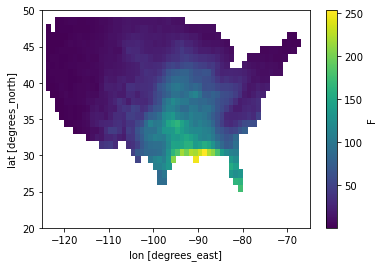

In [10]:
F_data.mean(dim='Time').plot()

## Read GEFS data

Read in the Hindcast dataset from GEFS model and Rename the coordinates from ('X', 'Y') to ('lon', 'lat')
- Variables:
    - CAPE: convective available potential energy (J/kg)
    - PR: precipitation (mm)
- The dimensions:
    - S: Start Time (forecast_reference_time): ordered from (0000 6 Jan 2010) to (0000 28 Dec 2016) by 7 (days)
    - M: Ensemble Member (realization): ordered from (0) to (10) by 1.0
    - L: Forecast Lead Time (forecast_period): ordered from (0.5 days) to (34.5 days) by 1.0 (days)
    - lon: The longitude; Notice that the range of this coordinate is from (0) to (360)
    - lat: The latitude; Notice that the order of this coordinate is from (90) to (-90)

In [11]:
GEFS_dataset = xr.open_mfdataset('/home/disk/eos12/wycheng/data/GEFS/GEFS*.nc',
                                 chunks={'S':'auto','M':'auto','L':'auto','X':'auto','Y':'auto'},
                                 parallel=True,
                                )\
                 .rename({'X': 'lon','Y': 'lat'})

Select the CONUS area

In [12]:
GEFS_dataset = GEFS_dataset.sel(lon=slice(235,295),lat=slice(50,20))

In [13]:
GEFS_dataset

<xarray.Dataset>
Dimensions:  (L: 35, M: 11, S: 365, lat: 31, lon: 61)
Coordinates:
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lon      (lon) float32 235.0 236.0 237.0 238.0 ... 292.0 293.0 294.0 295.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 24.0 23.0 22.0 21.0 20.0
Data variables:
    cape     (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 4, 5), meta=np.ndarray>
    pr       (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 4, 5), meta=np.ndarray>

- Reassign the longitude coordinate from (0, 360) to (-180, 180)
- Reverse the latitude coordinate from (60, 20) to (20, 60)

In [14]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    GEFS_dataset = GEFS_dataset.assign_coords(lon=(((GEFS_dataset.lon + 180) % 360) - 180)).reindex(lat=GEFS_dataset.lat[::-1])

In [15]:
GEFS_dataset

<xarray.Dataset>
Dimensions:  (L: 35, M: 11, S: 365, lat: 31, lon: 61)
Coordinates:
  * lat      (lat) float64 20.0 21.0 22.0 23.0 24.0 ... 46.0 47.0 48.0 49.0 50.0
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lon      (lon) float32 -125.0 -124.0 -123.0 -122.0 ... -67.0 -66.0 -65.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
Data variables:
    cape     (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 4, 5), meta=np.ndarray>
    pr       (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 4, 5), meta=np.ndarray>

Interpolate the data from integer grid point to half degree grid point to match the F data from WWLLN

In [16]:
lono = xr.DataArray(np.linspace(-124.5,-65.5,60), dims='lon')
lato = xr.DataArray(np.linspace(20.5,49.5,30), dims='lat')

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    GEFS_dataset = GEFS_dataset.interp(lon=lono,lat=lato,method='linear')

In [17]:
GEFS_dataset

<xarray.Dataset>
Dimensions:  (L: 35, M: 11, S: 365, lat: 30, lon: 60)
Coordinates:
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lon      (lon) float64 -124.5 -123.5 -122.5 -121.5 ... -67.5 -66.5 -65.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
Data variables:
    cape     (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 30, 60), meta=np.ndarray>
    pr       (S, M, L, lat, lon) float32 dask.array<chunksize=(44, 11, 35, 30, 60), meta=np.ndarray>

# Create CP data

In [18]:
CP_data_raw = (GEFS_dataset.cape * GEFS_dataset.pr).where( ~np.isnan(mask) )
CP_data_raw.name = 'CP_raw'
CP_data_raw

<xarray.DataArray 'CP_raw' (S: 365, M: 11, L: 35, lat: 30, lon: 60)>
dask.array<where, shape=(365, 11, 35, 30, 60), dtype=float32, chunksize=(44, 11, 35, 30, 60), chunktype=numpy.ndarray>
Coordinates:
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lon      (lon) float64 -124.5 -123.5 -122.5 -121.5 ... -67.5 -66.5 -65.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


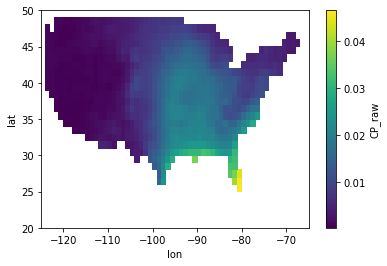

In [19]:
CP_data_raw.mean(dim={'S','M','L'}).plot()

# TK18: Fig 1

Turn the Start time and Lead time coordinates ('S', 'L') into forecast time coordinate (FCT) for later use

In [22]:
FCT_coor = xr.DataArray(
                        data=(CP_data_raw.S + CP_data_raw.L).stack(FCT={'S','L'}),
                        dims=['FCT'],
                        coords=dict(
                                    FCT=(['FCT'], (CP_data_raw.S + CP_data_raw.L).stack(FCT={'S','L'})),
                                   ),
                        attrs=None,
                       )
FCT_coor.name='FCT'
FCT_coor

<xarray.DataArray 'FCT' (FCT: 12775)>
array(['2010-01-06T12:00:00.000000000', '2010-01-07T12:00:00.000000000',
       '2010-01-08T12:00:00.000000000', ...,
       '2017-01-29T12:00:00.000000000', '2017-01-30T12:00:00.000000000',
       '2017-01-31T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * FCT      (FCT) datetime64[ns] 2010-01-06T12:00:00 ... 2017-01-31T12:00:00

## Generate CP forecast data

### Calculate the conversion coefficient (Ccpf) that convert CP to lightning flash rates. 

In TK18, the conversion coefficient is only a function of lead time and has no temporal and spatial variation. So for each lead time, we sum up all lightning strokes observed over different S (Start time), M (Ensemble members), X (longitude), and Y (latitude), and repeat the same for CP, and the ratio between the two is the conversion coefficient.

In [51]:
F_data_mean = F_data.mean(dim={'Time','lat','lon'}).values
F_data_mean

array(42.726227, dtype=float32)

In [52]:
CP_data_raw_SMXYmean = CP_data_raw.mean(dim={'S','M','lat','lon'}).values
CP_data_raw_SMXYmean

array([0.009056  , 0.00884824, 0.00843272, 0.00854588, 0.00873142,
       0.00895771, 0.00900012, 0.00935904, 0.00968126, 0.00977844,
       0.00965346, 0.00966959, 0.00982192, 0.00995581, 0.00991449,
       0.00975686, 0.00970936, 0.00980785, 0.00959386, 0.00961677,
       0.00949174, 0.00936412, 0.0094404 , 0.00943973, 0.00957763,
       0.00935427, 0.00942023, 0.00932866, 0.0093915 , 0.00936264,
       0.00924742, 0.00935302, 0.00919099, 0.00926562, 0.00907086],
      dtype=float32)

In [53]:
Ccpf = xr.DataArray(
    data=F_data_mean / CP_data_raw_SMXYmean,
    dims=['L'],
    coords=dict(
        L=(['L'], CP_data_raw.L.values),
    ),
    attrs=CP_data_raw.L.attrs
    ,
)

Text(0.5, 0, 'Lead time (days)')

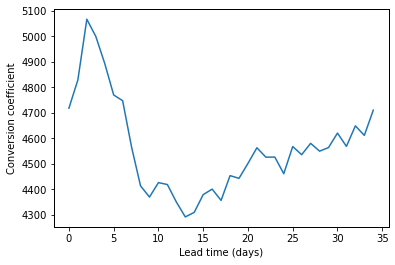

In [54]:
Ccpf.name='Ccpf'
plt.plot(Ccpf.values)
plt.ylabel('Conversion coefficient')
plt.xlabel('Lead time (days)')

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


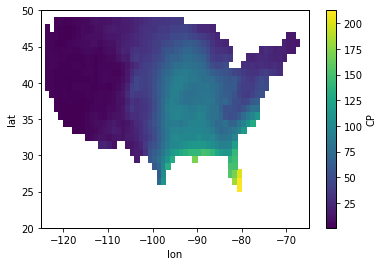

In [55]:
CP_data = Ccpf*CP_data_raw
CP_data.name='CP'
CP_data.persist()
CP_data.mean(dim={'S','M','L'}).plot()

### Calculate the CP threshold values that determine whether there is lightning event

Similar to finding the conversion coefficient, for each lead time, we calculate the total lightning events over different S, M, X, and Y, and then try to find the corresponding CP value that will have the same number of events (where CP is greater than this value). 

We first create a binary classification dataset that stores whether a lightning event is observed by WWLLN. When isL=1, more than 1 lightning strokes are observed by WWLLN; When isL=0, no lightning stroke is observed by WWLLN.

In [28]:
isL_data = F_data.where( (F_data<1) | (np.isnan(F_data)) , 1).persist()
isL_data.name = 'isL'
isL_data.persist()

<xarray.DataArray 'isL' (Time: 2557, lat: 30, lon: 60)>
dask.array<where, shape=(2557, 30, 60), dtype=float32, chunksize=(1, 30, 60), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 2010-01-02 ... 2016-12-31
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * lon      (lon) float32 -124.5 -123.5 -122.5 -121.5 ... -67.5 -66.5 -65.5

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


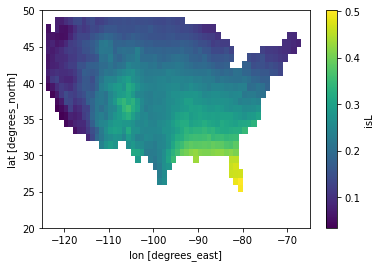

In [29]:
isL_data.mean(dim={'Time'}).plot()

Calculate the daily average of number of lightning events for normalization

In [30]:
isL_data_TXYsum = isL_data.sum(dim={'Time','lat','lon'}).values
isL_data_TXYsum

array(455367., dtype=float32)

This means that on average, there are approximately 455367/2557~=178 lightning events per day across CONUS. This will be used as the basis for normalization of binary CP classification.

In [56]:
"""
thrs = np.zeros((35))
for iL in range(35):
    print(iL)
    CP_data_sorted = np.sort(CP_data.isel(L=iL), axis=None)
    thrs[iL] = CP_data_sorted[::-1][np.sum(np.isnan(CP_data_sorted))+int(np.floor(isL_data_TXYsum)*(11*365/2557))]
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [57]:
#np.save('/home/disk/eos12/wycheng/data/metadata/thrs.npy', thrs)
thrs = np.load('/home/disk/eos12/wycheng/data/metadata/thrs.npy')

Text(0.5, 0, 'Lead time (days)')

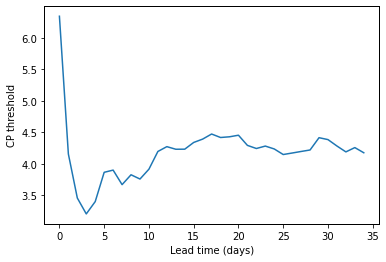

In [58]:
plt.plot(thrs)
plt.ylabel('CP threshold')
plt.xlabel('Lead time (days)')

In [59]:
CP_thrs = xr.DataArray(
    data=thrs,
    dims=['L'],
    coords=dict(
        L=(['L'], CP_data_raw.L.values),
    ),
    attrs=CP_data_raw.L.attrs
    ,
)
CP_thrs.name = 'cp_thrs'
CP_thrs

<xarray.DataArray 'cp_thrs' (L: 35)>
array([6.34186034, 4.15672093, 3.45844625, 3.20614169, 3.40172639,
       3.86612267, 3.90113427, 3.67061501, 3.82715255, 3.75940677,
       3.91597497, 4.19679235, 4.27330913, 4.23198365, 4.23309722,
       4.33981524, 4.39287881, 4.47355724, 4.4183825 , 4.42951932,
       4.45452279, 4.29343056, 4.24381131, 4.28228594, 4.23644407,
       4.14827417, 4.17205494, 4.19676926, 4.22036084, 4.4152606 ,
       4.38504698, 4.28349036, 4.19002314, 4.25835006, 4.1763443 ])
Coordinates:
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
Attributes:
    pointwidth:     0.0
    long_name:      Lead
    standard_name:  forecast_period
    gridtype:       0

In [60]:
#isCP_data = CP_data.where( (CP_data>40) | (np.isnan(CP_data)) , 0).where( (CP_data==0) | (np.isnan(CP_data)), 1)
isCP_data = xr.where(CP_data>CP_thrs, 1, 0).where(~np.isnan(CP_data))
isCP_data.name = 'isCP'
isCP_data.persist()

<xarray.DataArray 'isCP' (L: 35, S: 365, M: 11, lat: 30, lon: 60)>
dask.array<where, shape=(35, 365, 11, 30, 60), dtype=float64, chunksize=(35, 44, 11, 30, 60), chunktype=numpy.ndarray>
Coordinates:
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * S        (S) datetime64[ns] 2010-01-06 2010-01-13 ... 2016-12-21 2016-12-28
  * M        (M) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lon      (lon) float64 -124.5 -123.5 -122.5 -121.5 ... -67.5 -66.5 -65.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5

Just to double check, should be pretty close 178

In [61]:
isCP_data_SMmean_XYsum = isCP_data.isel(L=slice(0,7)).mean(dim={'S','M'}).sum(dim={'lat','lon'}).values
isCP_data_SMmean_XYsum

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array([178.08617684, 178.0864259 , 178.08617684, 178.08592777,
       178.0864259 , 178.0864259 , 178.0864259 ])

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


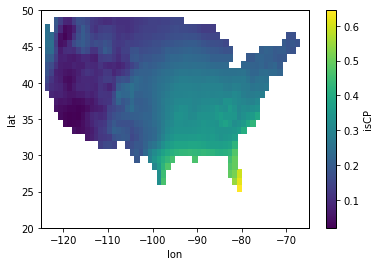

In [62]:
isCP_data.isel(L=slice(0,7)).mean(dim={'S','M','L'}).plot()

## Plotting

In [38]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [39]:
def plot_map(figsize,data,cmap,vmin=None,vmax=None,title=None,unit=None):
    
    plt.rcParams.update({'font.size': 48})
    
    xlim    = (-125,-65)
    ylim    = (25,50)
    
    pcm = xr.plot.pcolormesh(data,"lon","lat",
                             figsize=figsize,
                             xlim=xlim,
                             ylim=ylim,
                             cmap=cmap,
                             vmin=vmin,
                             vmax=vmax,
                             add_colorbar=True,
                            )

    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    
    plt.rcParams.update({'font.size': 10})

## Figure 1

### Fig 1a

In [40]:
data1a = F_data.mean(dim='Time').where( ~np.isnan(mask) ).persist()

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


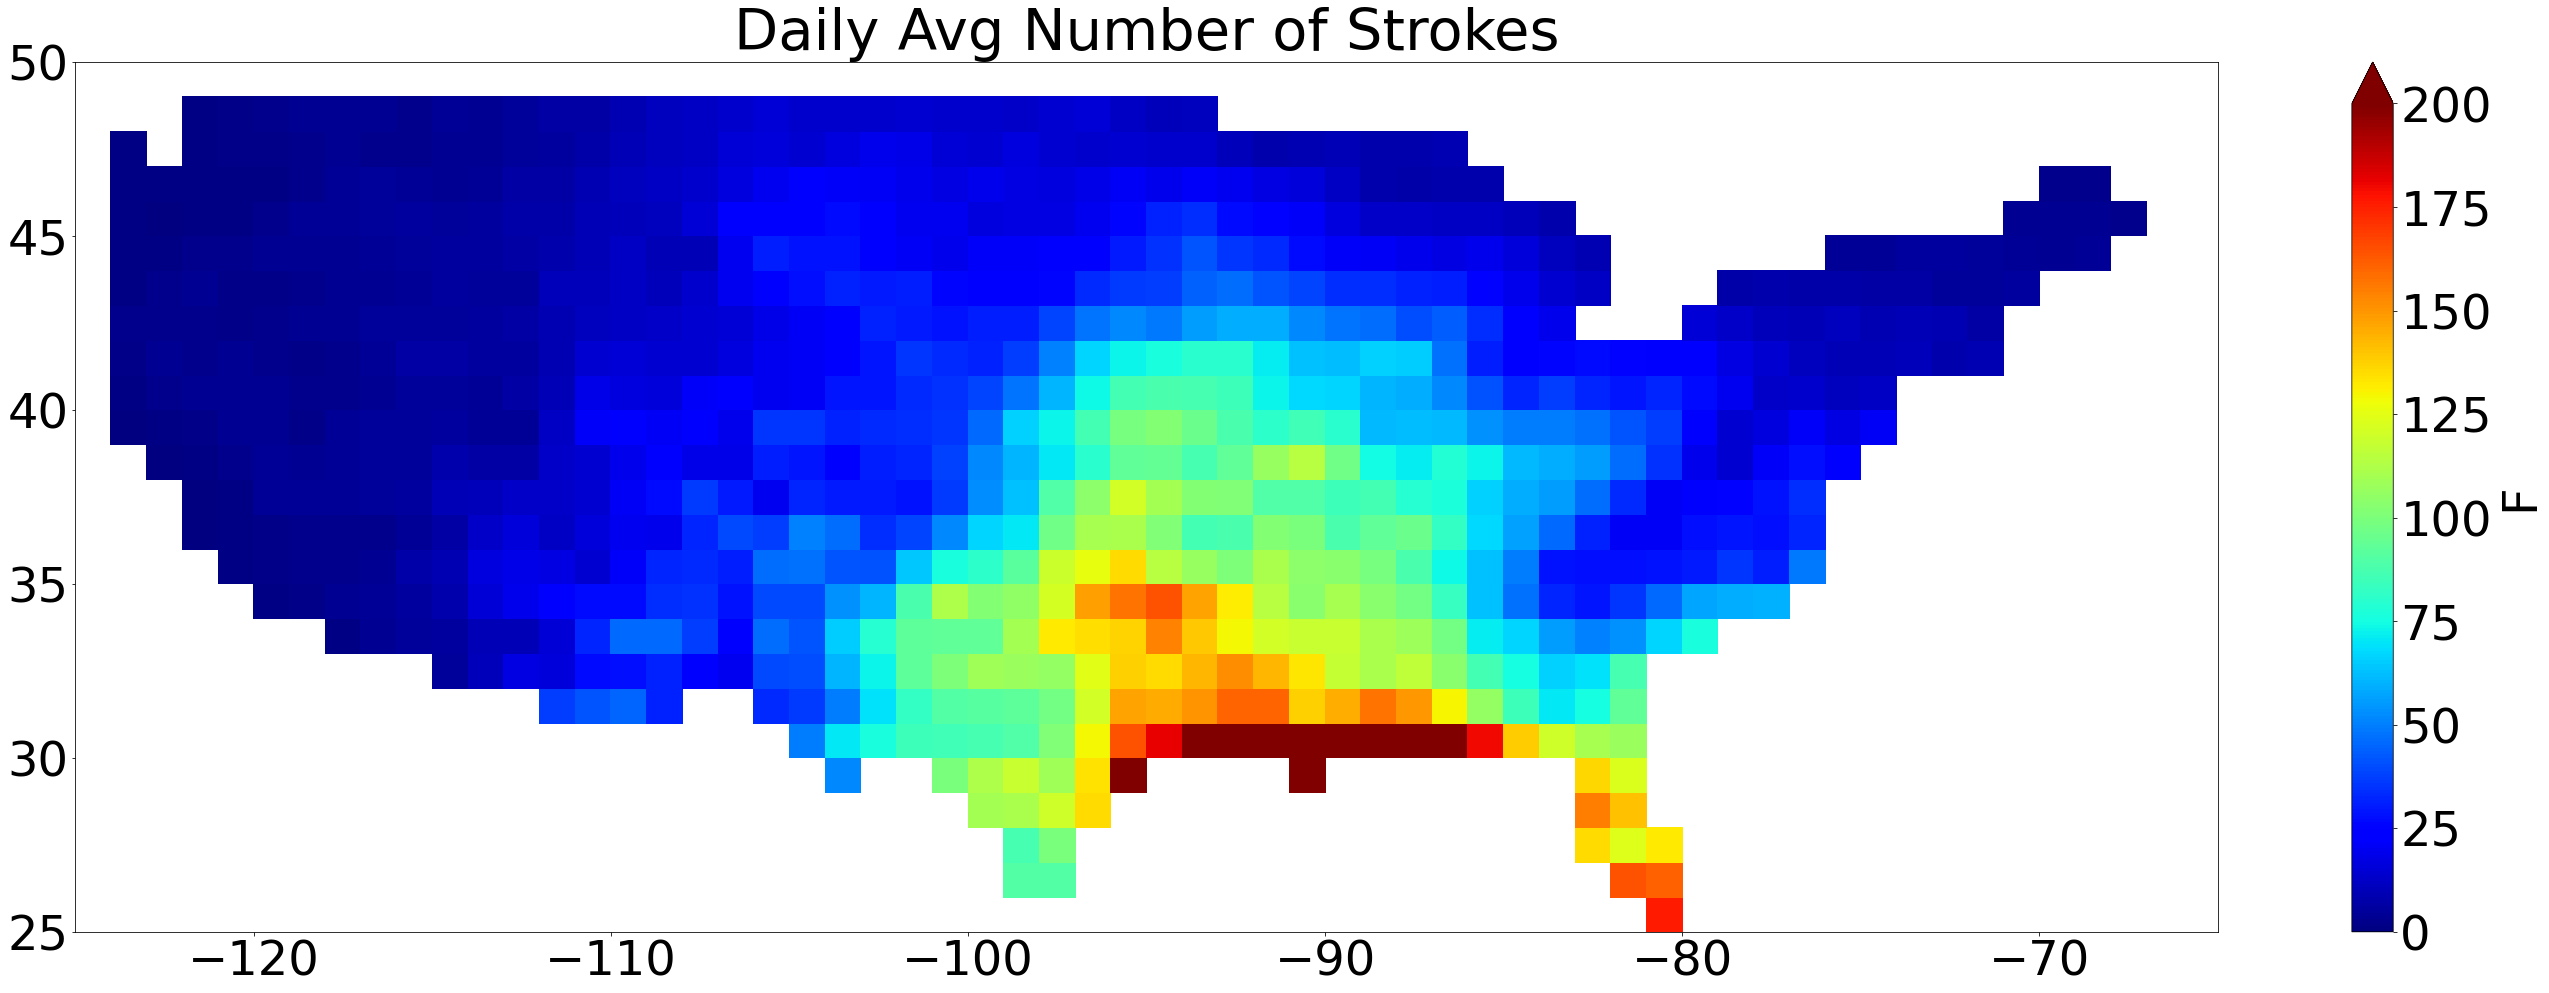

In [41]:
figsize = (48,16)
cmap    = plt.get_cmap('jet')
vmin    = 0
vmax    = 200
title   = 'Daily Avg Number of Strokes'
unit    = ''

plot_map(figsize,data1a,cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)
#plt.savefig('TK18_Fig1a.png')

### Fig 1b

In [63]:
data1b = CP_data.isel(L=slice(0,7)).mean(dim={'S','M','L'}).where( ~np.isnan(mask) ).persist()

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


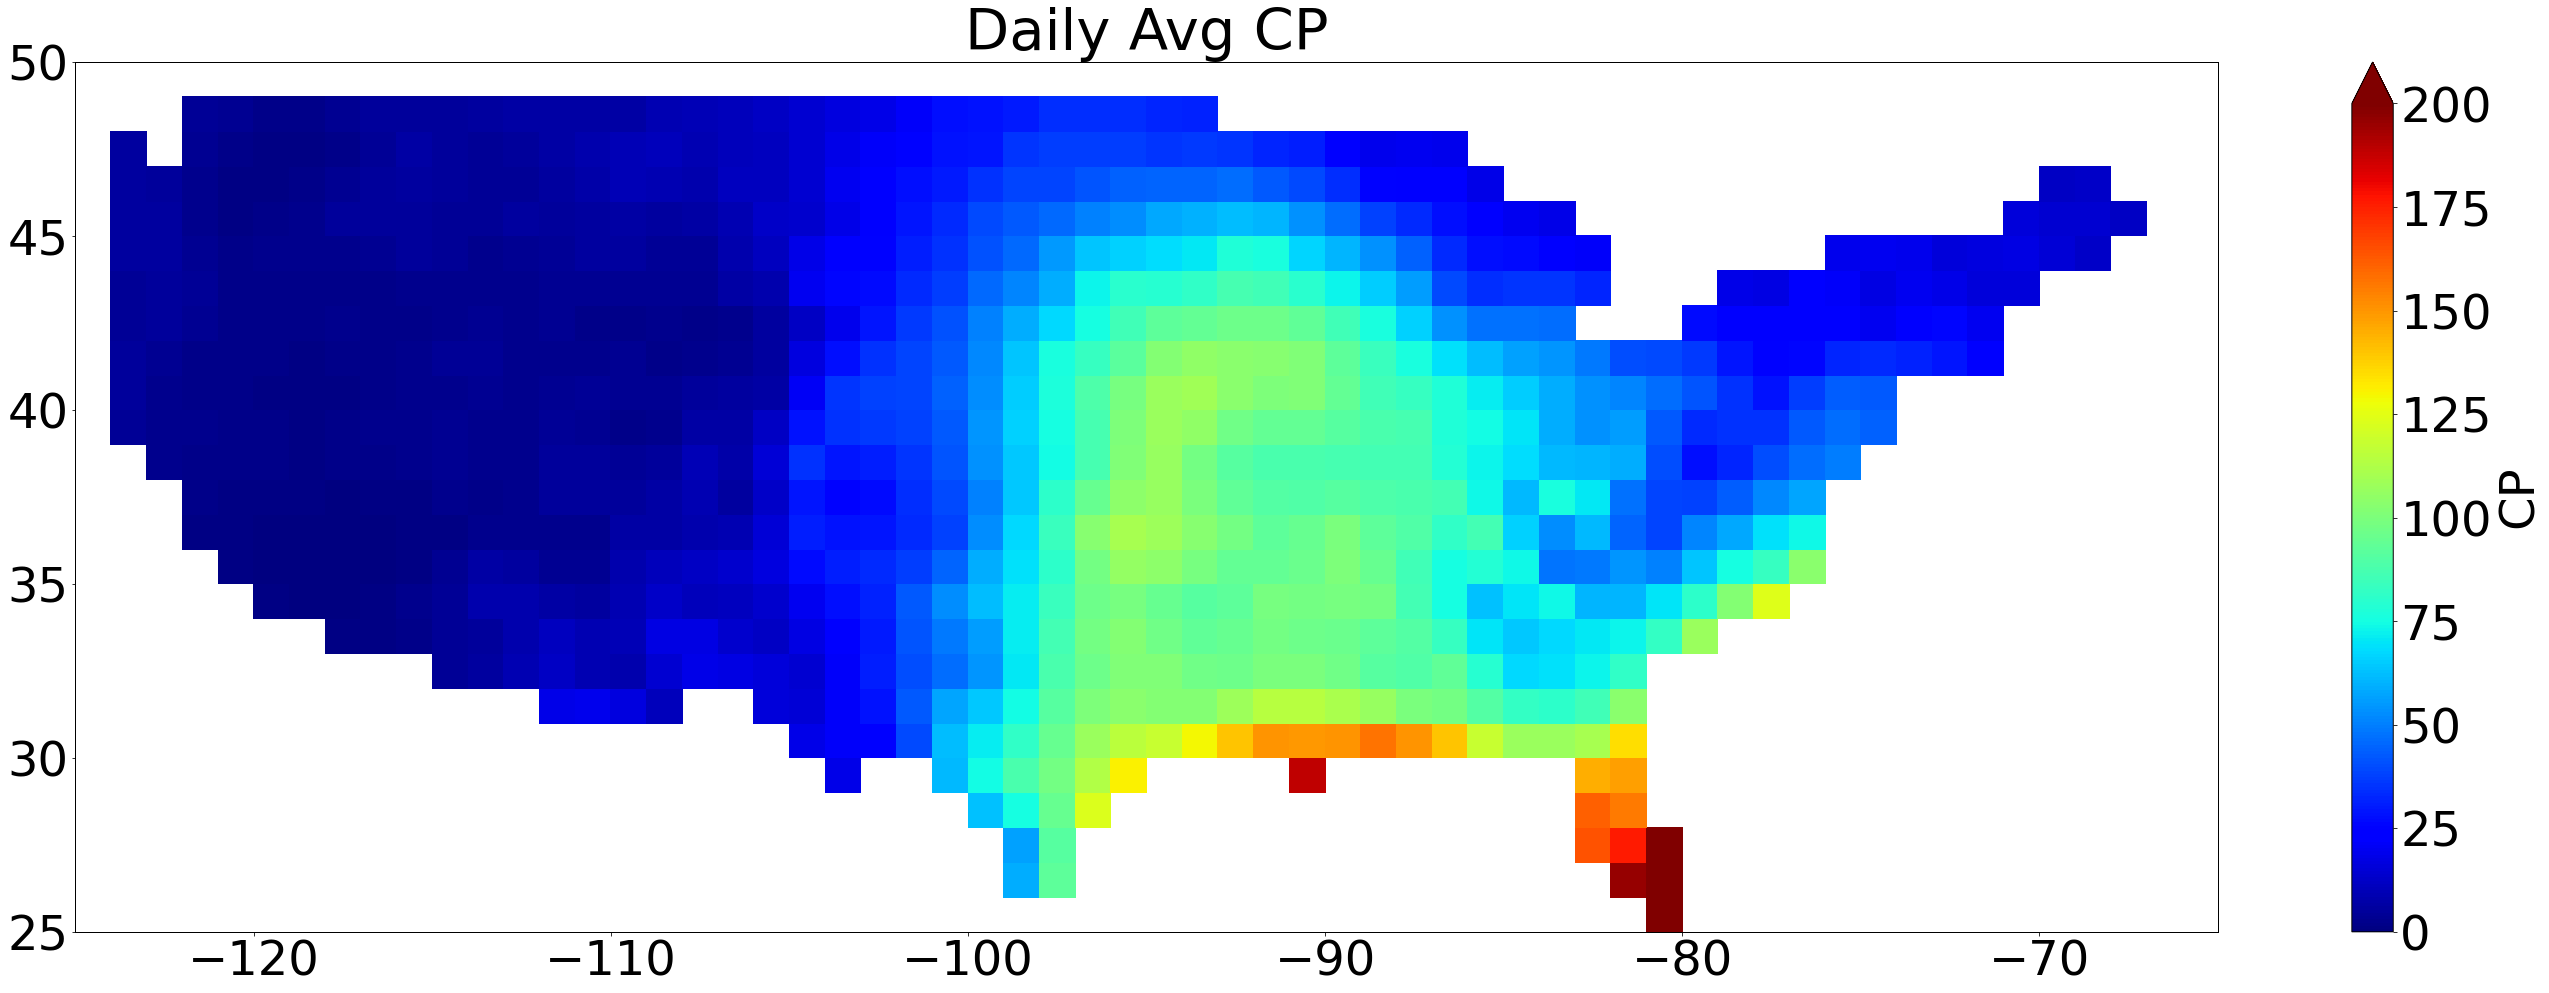

In [64]:
figsize = (48,16)
cmap    = plt.get_cmap('jet')
vmin    = 0
vmax    = 200
title   = 'Daily Avg CP'
unit    = ''

plot_map(figsize,data=data1b,cmap=cmap,vmin=vmin,vmax=vmax,title=title,unit=unit)
#plt.savefig('TK18_Fig1b.png')

### Fig 1c

In [65]:
 _, index = np.unique(FCT_coor['FCT'], return_index=True)
fig1cd_coor = FCT_coor.isel(FCT=index).sel(FCT=slice("2011-01-01", "2011-12-31"))
fig1cd_coor

<xarray.DataArray 'FCT' (FCT: 365)>
array(['2011-01-01T12:00:00.000000000', '2011-01-02T12:00:00.000000000',
       '2011-01-03T12:00:00.000000000', '2011-01-04T12:00:00.000000000',
       '2011-01-05T12:00:00.000000000', '2011-01-06T12:00:00.000000000',
       '2011-01-07T12:00:00.000000000', '2011-01-08T12:00:00.000000000',
       '2011-01-09T12:00:00.000000000', '2011-01-10T12:00:00.000000000',
       '2011-01-11T12:00:00.000000000', '2011-01-12T12:00:00.000000000',
       '2011-01-13T12:00:00.000000000', '2011-01-14T12:00:00.000000000',
       '2011-01-15T12:00:00.000000000', '2011-01-16T12:00:00.000000000',
       '2011-01-17T12:00:00.000000000', '2011-01-18T12:00:00.000000000',
       '2011-01-19T12:00:00.000000000', '2011-01-20T12:00:00.000000000',
       '2011-01-21T12:00:00.000000000', '2011-01-22T12:00:00.000000000',
       '2011-01-23T12:00:00.000000000', '2011-01-24T12:00:00.000000000',
       '2011-01-25T12:00:00.000000000', '2011-01-26T12:00:00.000000000',
       '2011-01-27T12:00:00.000000000', '2011-01-28T12:00:00.000000000',
       '2011-01-29T12:00:00.000000000', '2011-01-30T12:00:00.000000000',
       '2011-01-31T12:00:00.000000000', '2011-02-01T12:00:00.000000000',
       '2011-02-02T12:00:00.000000000', '2011-02-03T12:00:00.000000000',
       '2011-02-04T12:00:00.000000000', '2011-02-05T12:00:00.000000000',
       '2011-02-06T12:00:00.000000000', '2011-02-07T12:00:00.000000000',
       '2011-02-08T12:00:00.000000000', '2011-02-09T12:00:00.000000000',
...
       '2011-11-23T12:00:00.000000000', '2011-11-24T12:00:00.000000000',
       '2011-11-25T12:00:00.000000000', '2011-11-26T12:00:00.000000000',
       '2011-11-27T12:00:00.000000000', '2011-11-28T12:00:00.000000000',
       '2011-11-29T12:00:00.000000000', '2011-11-30T12:00:00.000000000',
       '2011-12-01T12:00:00.000000000', '2011-12-02T12:00:00.000000000',
       '2011-12-03T12:00:00.000000000', '2011-12-04T12:00:00.000000000',
       '2011-12-05T12:00:00.000000000', '2011-12-06T12:00:00.000000000',
       '2011-12-07T12:00:00.000000000', '2011-12-08T12:00:00.000000000',
       '2011-12-09T12:00:00.000000000', '2011-12-10T12:00:00.000000000',
       '2011-12-11T12:00:00.000000000', '2011-12-12T12:00:00.000000000',
       '2011-12-13T12:00:00.000000000', '2011-12-14T12:00:00.000000000',
       '2011-12-15T12:00:00.000000000', '2011-12-16T12:00:00.000000000',
       '2011-12-17T12:00:00.000000000', '2011-12-18T12:00:00.000000000',
       '2011-12-19T12:00:00.000000000', '2011-12-20T12:00:00.000000000',
       '2011-12-21T12:00:00.000000000', '2011-12-22T12:00:00.000000000',
       '2011-12-23T12:00:00.000000000', '2011-12-24T12:00:00.000000000',
       '2011-12-25T12:00:00.000000000', '2011-12-26T12:00:00.000000000',
       '2011-12-27T12:00:00.000000000', '2011-12-28T12:00:00.000000000',
       '2011-12-29T12:00:00.000000000', '2011-12-30T12:00:00.000000000',
       '2011-12-31T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * FCT      (FCT) datetime64[ns] 2011-01-01T12:00:00 ... 2011-12-31T12:00:00

In [66]:
F_data_1c = F_data.sel(Time=slice("2011-01-01", "2011-12-31")).sum(dim={'lat','lon'}).persist()
F_data_1c.name = 'F_data_1c'
F_data_1c

<xarray.DataArray 'F_data_1c' (Time: 365)>
dask.array<sum-aggregate, shape=(365,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31

In [67]:
CP_data_1c = xr.DataArray(
                          data=CP_data.isel(L=slice(0,7)).stack(FCT=('S', 'L')).sum(dim={'lat','lon'}).mean('M'),
                          dims=['FCT'],
                          coords=dict(
                                      FCT=(['FCT'], (CP_data.isel(L=slice(0,7)).S + CP_data.isel(L=slice(0,7)).L).stack(FCT=('S', 'L'))),
                                     ),
                          attrs=None,
                         ).sel(FCT=slice("2011-01-01", "2011-12-31")).persist()
CP_data_1c.name= 'CP_data_1c'
CP_data_1c

<xarray.DataArray 'CP_data_1c' (FCT: 365)>
array([2.42773262e+04, 2.57843384e+03, 1.91630600e+02, 4.37516205e+02,
       2.63064233e+03, 1.13534656e+03, 3.32943954e+01, 2.41965576e+02,
       1.65134802e+03, 5.37700745e+02, 6.28999268e+02, 3.26389038e+02,
       4.55814758e+02, 1.54623642e+02, 5.61596985e+02, 7.33933167e+02,
       2.00888049e+03, 4.70403467e+03, 3.84355103e+02, 7.84799118e+01,
       5.97589966e+02, 1.28467010e+02, 4.19090385e+01, 7.01918579e+02,
       2.04452148e+03, 4.87393018e+03, 1.16323090e+01, 2.11707706e+01,
       9.40041809e+01, 1.31478943e+03, 7.21389160e+02, 2.02509729e+03,
       3.46667358e+03, 3.33407410e+02, 3.54004761e+02, 5.76905945e+02,
       2.12207428e+02, 1.20390770e+02, 8.90179688e+02, 8.94734421e+01,
       1.15923584e+02, 1.28043320e+02, 6.29932747e+01, 8.93686295e+01,
       6.17736092e+01, 2.93017120e+02, 2.49596729e+03, 9.05867615e+02,
       6.69772034e+02, 6.40097595e+02, 2.64518384e+03, 2.93227710e+03,
       8.99079712e+02, 9.16936462e+02, 1.52572617e+04, 5.80457471e+03,
       4.63058594e+02, 8.99159863e+03, 1.42133223e+04, 8.31709167e+02,
       3.52672363e+02, 7.20938660e+02, 3.23473901e+03, 2.69835547e+04,
       5.15394092e+03, 1.65106128e+03, 1.18833154e+03, 3.74811328e+04,
       1.01197402e+04, 8.75824768e+02, 2.63429169e+02, 7.90099609e+02,
       4.70647119e+03, 1.69519299e+03, 4.01769824e+03, 1.10438550e+03,
       1.79770068e+03, 6.34447168e+03, 6.57527637e+03, 1.20662441e+04,
...
       4.77997467e+02, 1.43929919e+03, 4.84534717e+03, 2.26998809e+04,
       3.54925781e+03, 9.73100510e+01, 8.55636963e+02, 5.30739648e+03,
       8.83471252e+02, 2.46780103e+03, 3.16922241e+03, 3.01830151e+03,
       2.67963623e+03, 2.39194360e+03, 3.97766205e+02, 6.90010315e+02,
       6.68724121e+02, 2.24736938e+03, 1.54343872e+03, 1.07338354e+03,
       5.22748291e+02, 9.44305298e+02, 6.33042822e+03, 1.52059248e+04,
       8.81931738e+03, 2.57606842e+02, 2.01547546e+02, 4.77244263e+02,
       6.74252563e+02, 4.24036133e+03, 1.18576699e+04, 2.36968555e+04,
       6.83118018e+03, 8.02448608e+02, 4.12903687e+02, 1.03829951e+04,
       2.60145605e+04, 2.81159062e+04, 8.24802930e+03, 1.51205093e+02,
       8.23599243e+02, 6.30199414e+03, 2.41087598e+03, 1.24725879e+03,
       1.06453955e+03, 5.44983826e+02, 1.50450773e+01, 5.60131226e+02,
       2.84349585e+03, 4.62028320e+03, 2.07397803e+03, 1.00906366e+03,
       2.30464355e+03, 3.00797577e+02, 9.90606689e+01, 2.75755096e+02,
       1.41723740e+02, 2.06648483e+02, 2.38432312e+02, 9.11119629e+03,
       6.37213232e+03, 1.48327600e+03, 1.38591980e+03, 1.62718506e+03,
       6.14325195e+03, 3.46993433e+03, 6.55412988e+03, 5.54969727e+03,
       1.54737415e+03, 1.84608871e+02, 2.54421875e+02, 1.61723068e+02,
       3.77798431e+02, 9.55532471e+02, 6.21718018e+02, 8.02311096e+02,
       4.52748657e+02], dtype=float32)
Coordinates:
  * FCT      (FCT) datetime64[ns] 2011-01-01T12:00:00 ... 2011-12-31T12:00:00

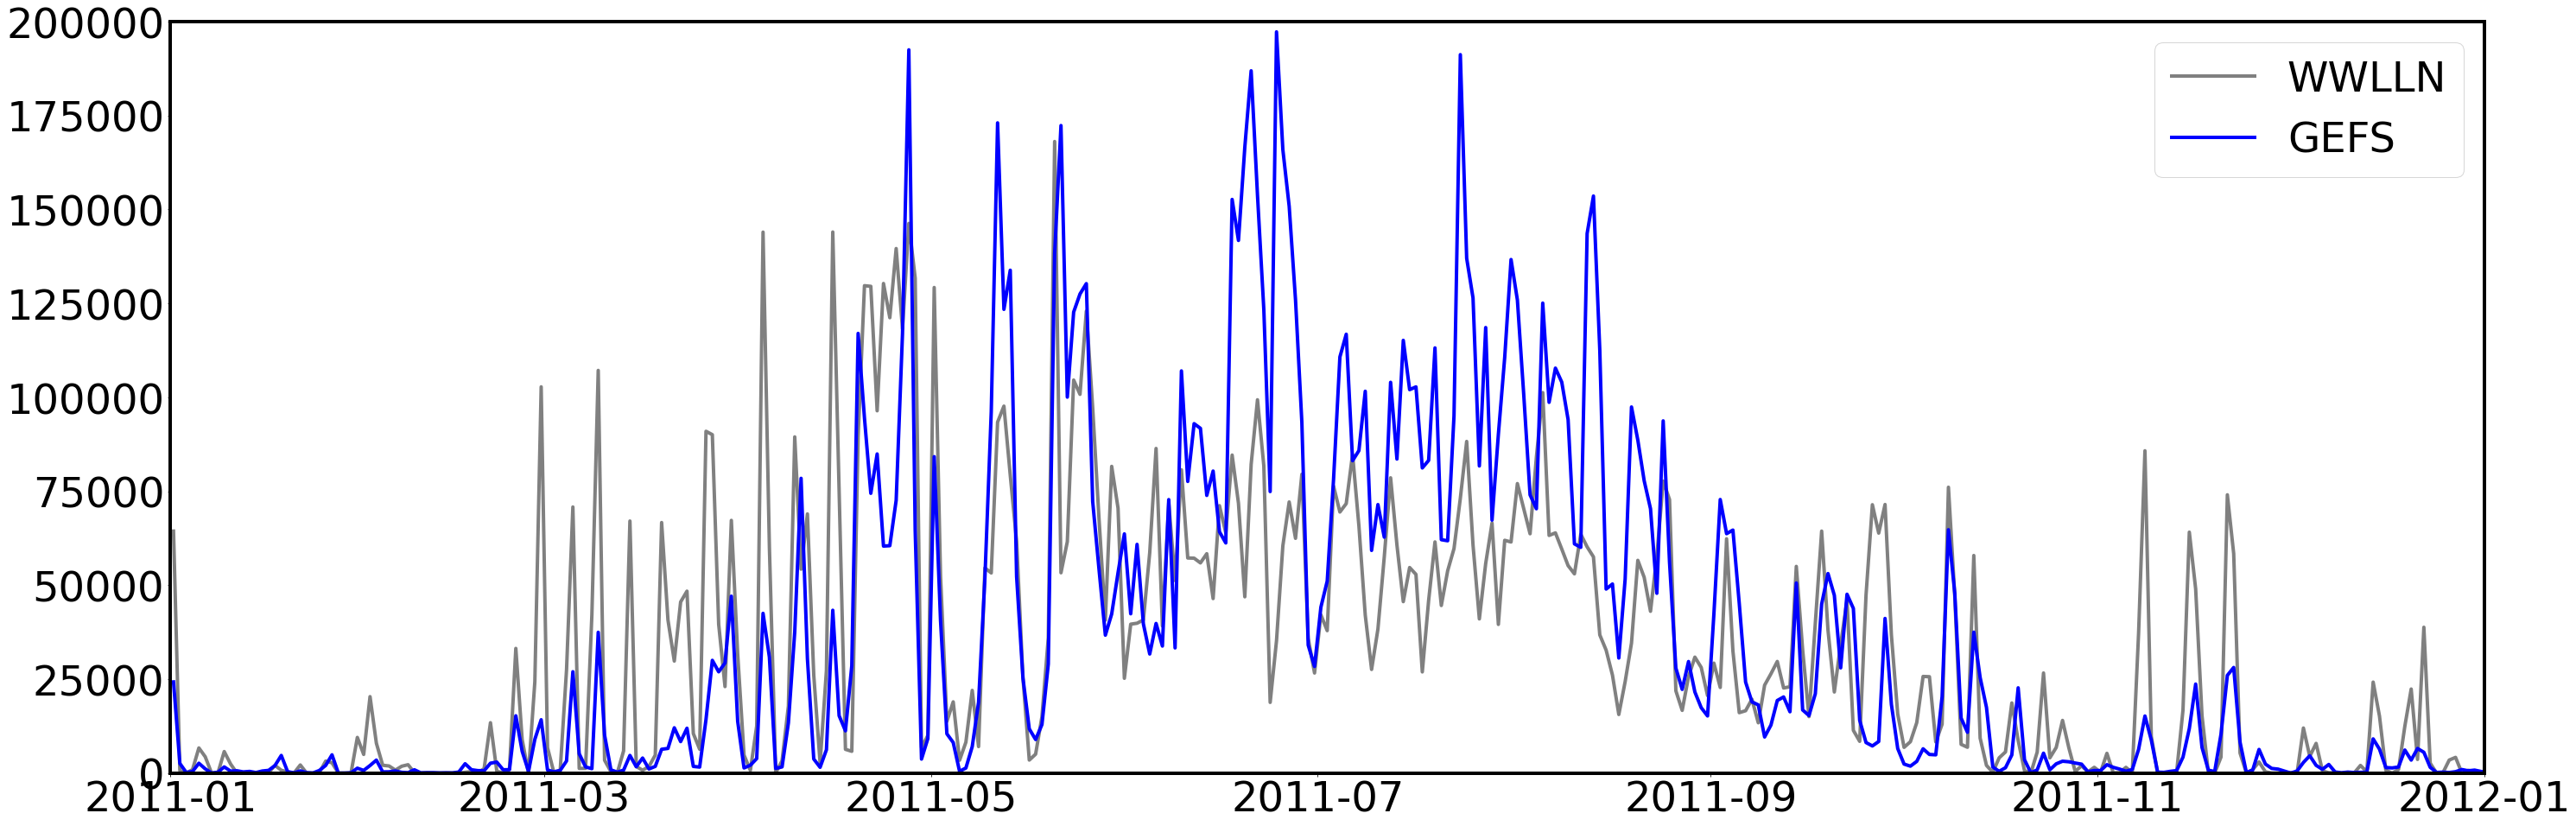

In [68]:
figsize = (48,16)
matplotlib.rcParams['axes.linewidth'] = 4
plt.rcParams.update({'font.size': 48})

fig = plt.figure(figsize=figsize)
ax  = fig.add_subplot(111)

ax.plot(fig1cd_coor, F_data_1c, label='WWLLN', color='gray', linewidth=4)
ax.plot(fig1cd_coor, CP_data_1c, label='GEFS', color='blue', linewidth=4)

ax.set_xlim(14975,15340)
ax.set_ylim(0,200000)

plt.legend()
#plt.savefig('TK18_Fig1c.png')

matplotlib.rcParams['axes.linewidth'] = 1
plt.rcParams.update({'font.size': 10})

### Fig 1d

In [69]:
isL_data_1d = isL_data.sel(Time=slice("2011-01-01", "2011-12-31")).sum(dim={'lat','lon'}).persist()
isL_data_1d

<xarray.DataArray 'isL' (Time: 365)>
dask.array<sum-aggregate, shape=(365,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2011-01-01 2011-01-02 ... 2011-12-31

In [70]:
isCP_data_1d = xr.DataArray(
                            data=isCP_data.isel(L=slice(0,7)).stack(FCT=('S', 'L')).sum(dim={'lat','lon'}).mean('M'),
                            dims=['FCT'],
                            coords=dict(
                                        FCT=(['FCT'], (isCP_data.isel(L=slice(0,7)).S + isCP_data.isel(L=slice(0,7)).L).stack(FCT=('S', 'L'))),
                                       ),
                            attrs=None,
                           ).sel(FCT=slice("2011-01-01", "2011-12-31")).persist()
isCP_data_1d.name= 'isCP_data_1d'
isCP_data_1d

<xarray.DataArray 'isCP_data_1d' (FCT: 365)>
array([115.18181818,  59.        ,  10.36363636,  13.18181818,
        55.27272727,  16.63636364,   1.09090909,  13.90909091,
        31.63636364,  19.27272727,  13.90909091,  13.36363636,
        25.36363636,  12.09090909,  38.63636364,  39.45454545,
        63.81818182,  73.36363636,   7.        ,   2.18181818,
        14.27272727,   6.72727273,   1.18181818,  25.54545455,
        32.18181818,  43.09090909,   0.45454545,   0.45454545,
         5.90909091,  31.27272727,  24.54545455,  54.81818182,
        79.54545455,   9.72727273,  17.        ,  33.09090909,
        19.63636364,   5.        ,  32.45454545,   0.45454545,
         2.45454545,   3.09090909,   3.45454545,   5.63636364,
         2.63636364,  20.27272727,  95.        ,  54.36363636,
        47.81818182,  36.36363636, 115.90909091,  86.90909091,
        56.36363636,  43.45454545, 163.72727273, 170.54545455,
        33.45454545, 156.45454545, 211.45454545,  41.27272727,
        17.18181818,  37.        , 132.09090909, 193.81818182,
       121.45454545,  53.        ,  59.        , 143.18181818,
       151.09090909,  56.        ,  16.90909091,  45.45454545,
       110.54545455,  72.72727273, 149.45454545,  83.        ,
       102.72727273, 154.72727273, 145.18181818, 182.54545455,
...
        13.09090909,  32.        ,  95.18181818, 140.27272727,
        81.09090909,   6.36363636,  23.18181818,  84.09090909,
        38.45454545,  56.09090909, 110.63636364, 123.27272727,
        24.72727273,  31.36363636,   9.63636364,  12.81818182,
        14.54545455,  59.45454545,  78.        ,  40.27272727,
        44.54545455,  31.63636364,  80.27272727, 153.63636364,
       112.81818182,  10.63636364,  13.        ,  17.90909091,
        47.90909091, 129.18181818, 157.81818182, 171.09090909,
       101.45454545,  58.63636364,  25.09090909, 164.90909091,
       182.90909091, 186.54545455, 142.18181818,   8.63636364,
        51.45454545,  99.45454545,  85.18181818,  58.81818182,
        34.        ,  27.45454545,   0.        ,  42.        ,
        85.45454545,  77.63636364,  60.90909091,  40.45454545,
        72.45454545,  14.54545455,   5.        ,   6.54545455,
         5.72727273,   7.18181818,  14.54545455, 116.09090909,
       140.90909091,  57.18181818,  24.90909091,  35.09090909,
        74.63636364,  66.72727273, 113.27272727,  92.09090909,
        62.        ,   9.63636364,  15.09090909,   8.63636364,
        12.18181818,  31.72727273,  37.18181818,  38.54545455,
        33.36363636])
Coordinates:
  * FCT      (FCT) datetime64[ns] 2011-01-01T12:00:00 ... 2011-12-31T12:00:00

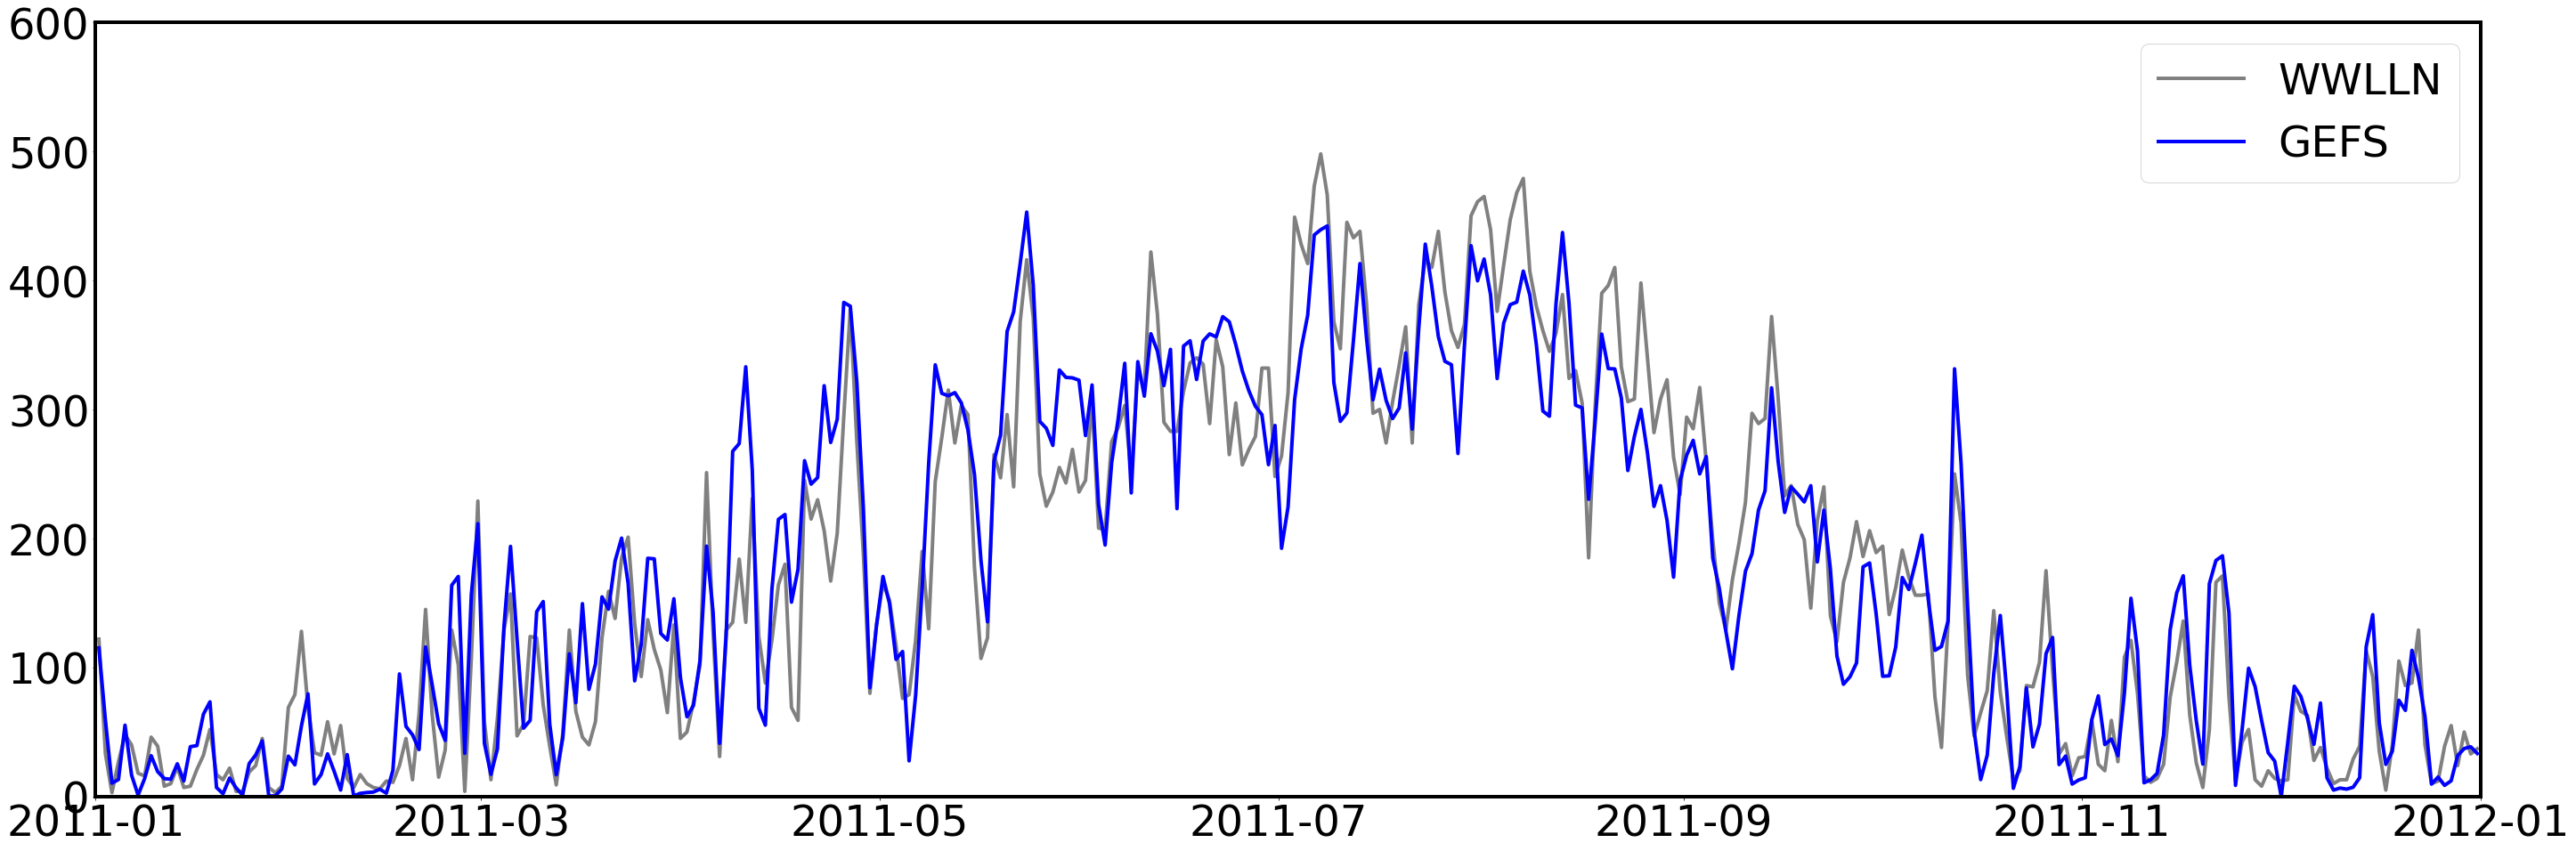

In [71]:
figsize = (48,16)
plt.rcParams.update({'font.size': 48})
matplotlib.rcParams['axes.linewidth'] = 4

fig = plt.figure(figsize=figsize)
ax  = fig.add_subplot(111)

ax.plot(fig1cd_coor, isL_data_1d, label='WWLLN', color='gray', linewidth=4)
ax.plot(fig1cd_coor, isCP_data_1d, label='GEFS', color='blue', linewidth=4)

ax.set_xlim(14975,15340)
ax.set_ylim(0,600)

plt.legend()
#plt.savefig('TK18_Fig1d.png')

matplotlib.rcParams['axes.linewidth'] = 1
plt.rcParams.update({'font.size': 10})

## Figure 2

### Fig 2a - 2b